# Global X Copper Miners ETF Price Prediction Capstone Project

## Project Overview
For the 12-month period that ended in November 2021, the **[US inflation rate](https://www.bls.gov/cpi/)** rose to 6.8%, its highest since 1982. To protect one's assets, it is wise to invest in assets that performs well during inflationary periods. Historically, copper is one of the best performing assets during inflationary periods. As a result, predicting changes in the value of copper has obvious financial benefit including knowing when to buy or sell.

From an investor point of view, it would be very beneficial if one could predict a stock future price. It is this desire to attempt to predict a stock future price that is begind this project. Indeed, with this project, we will attempt to create a machine learning model that could predict the next day's price of copper based on historical data.

This project is divided into three parts. The first part of the projected deals with the acquisition, analysis and preparation of the data. The second part of the project really on Scikit-learn (Sklearn) to create three distinct machine learning models and pick the best performing one. The third and final part of the project will implement and deploy model usinf Amazon Web Services (AWS).

## Part 1 - Data Acquisition and Preparation

## Install Python Package in the Current Jupyter Kernel

For this Jupyter Notebook to run properly, the following Python package need to be installed in the current kernel.

In [1]:
import sys

# One of the leading high-level neural networks APIs
!{sys.executable} -m pip -q install keras

# An end-to-end open source platform for machine learning
!{sys.executable} -m pip -q install tensorflow

# Up-to-date remote data access for pandas. Works for multiple versions of pandas.
!{sys.executable} -m pip -q install pandas-datareader

### Import Relevant Libraries

The following Python libraries will be needed for this project. Therefore, one of the first step that we must take is to import them into our environment.

In [2]:
# io provides Python’s main facilities for dealing with various types of I/O. There are three main types of I/O: text I/O, binary I/O and raw I/O
import io

# os provides a portable way of using operating system dependent functionality
import os

# sys provides various functions and variables that are used to manipulate different parts of the Python runtime environment
import sys

# json makes it easy to parse JSON strings and files containing JSON object
import json

# math provides access to the mathematical functions defined by the C standard
import math

# boto3 makes it easy to integrate Python application, library, or script with AWS services including Amazon S3
import boto3

# warnings has a way to warn programmers about changes in language or library features
import warnings
warnings.filterwarnings("ignore")

# sagemaker is an open source library for training and deploying machine learning models on Amazon SageMaker
import sagemaker

# numpy and pandas are used for data manipulation
import numpy as np
import pandas as pd

# seaborn is used for plotting graphs
import seaborn as sns

# datetime is used to manipulate dates and times
import datetime as dt

# matplotlib is used for plotting graphs
import matplotlib.pyplot as plt

# pandas_datareader is used for remote data access
import pandas_datareader as pdr

# import sagemaker common library
import sagemaker.amazon.common as smac

# Sequential groups a linear stack of layers into a model
from keras.models import Sequential

# r2_score returns the coefficient of determination
from sklearn.metrics import r2_score

# LSTM is a machine learning library for Long Short-Term Memory model
from keras.layers.recurrent import LSTM

# get_execution_role return the IAM role created for the current notebook instance
from sagemaker import get_execution_role

# TrainingInput create a definition for input data used by an SageMaker training job
from sagemaker.session import TrainingInput

# mean_squared_error returns the mean squared error regression loss
from sklearn.metrics import mean_squared_error

# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# RandomForestRegressor is a classification algorithm made up of several decision trees
from sklearn.ensemble import RandomForestRegressor

# train_test_split splits datasets into two subsets
from sklearn.model_selection import train_test_split

# Layers are the basic building blocks of neural networks in Keras
from keras.layers.core import Dense, Activation, Dropout

%matplotlib inline
sns.set_style('darkgrid')

### Data Exploration and Visualization

#### Data Download using the 'pandas_datareader' Library

The Global X Copper Miners ETF ('**COPX**') was created on April 19, 2010. It is tied to the copper mining industry. Its historical data will be downloaded directly from Yahoo Finance! The data will then be stored into the instance's environment.

In [3]:
# Get the data

ticker = 'COPX'                                      # stock ticker symbol
    
fileName = 'stock_market_data-{}.csv'.format(ticker) # save data to this file

start = dt.datetime(2010, 4, 19)                     # inception date: 04/19/2010
end = dt.datetime(2021, 12, 31)                      # last day of 2021: 12/31/2021

print('Downloading data from the Internet')
df = pdr.get_data_yahoo(ticker, start, end)
df.to_csv(fileName)

In [4]:
# Upload newly downloaded data to S3
bucket = 'project-6'

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('data', fileName)).upload_file(fileName)

#### Explore and clean the data

In [5]:
# Inspect the data
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-04-20,44.700001,43.950001,44.700001,44.040001,1933.0,34.699127
2010-04-21,44.099998,43.230000,43.799999,43.349998,2900.0,34.155479
2010-04-22,43.169998,42.509998,43.169998,43.110001,3600.0,33.966377
2010-04-23,43.259998,42.750000,42.959999,43.259998,1100.0,34.084560
2010-04-26,44.880001,43.200001,44.880001,43.919998,3600.0,34.604576


In [6]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-27,37.139999,36.639999,36.799999,37.070000,493600.0,36.685104
2021-12-28,37.220001,36.650002,37.040001,36.919998,174100.0,36.536659
2021-12-29,37.310001,36.900002,37.000000,37.080002,213100.0,36.695004
2021-12-30,37.070000,36.619999,36.880001,36.650002,269100.0,36.650002
2021-12-31,37.070000,36.669998,36.669998,36.910000,309800.0,36.910000


In [7]:
# Show some summary statistics
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2948.000000,2948.000000,2948.000000,2948.000000,2.948000e+03,2948.000000
mean,28.985098,28.402266,28.736794,28.691750,9.247461e+04,25.407785
std,11.685435,11.431293,11.595292,11.557934,2.768949e+05,8.987369
min,9.200000,8.660000,9.090000,9.080000,0.000000e+00,8.294188
25%,20.250000,19.900000,20.127500,20.129999,9.200000e+03,18.898531
50%,26.535001,26.129999,26.370001,26.295000,2.220000e+04,23.900860
75%,36.637501,35.764998,36.304999,36.187500,5.804975e+04,31.935897
max,62.939999,62.130001,62.759998,62.220001,5.902300e+06,49.256039


In [8]:
# Display a concise summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2948 entries, 2010-04-20 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2948 non-null   float64
 1   Low        2948 non-null   float64
 2   Open       2948 non-null   float64
 3   Close      2948 non-null   float64
 4   Volume     2948 non-null   float64
 5   Adj Close  2948 non-null   float64
dtypes: float64(6)
memory usage: 161.2 KB


#### Prepare the data

The ‘Date’ column will be converted to a DatetimeIndex.

In [9]:
# Drop rows with any empty cells (if any)
if df.isnull().any().any():
    print('Empty cells found - rows dropped')
    df.dropna(axis=0, how='any', inplace=True)
else:
    print('No empty cells found')

No empty cells found


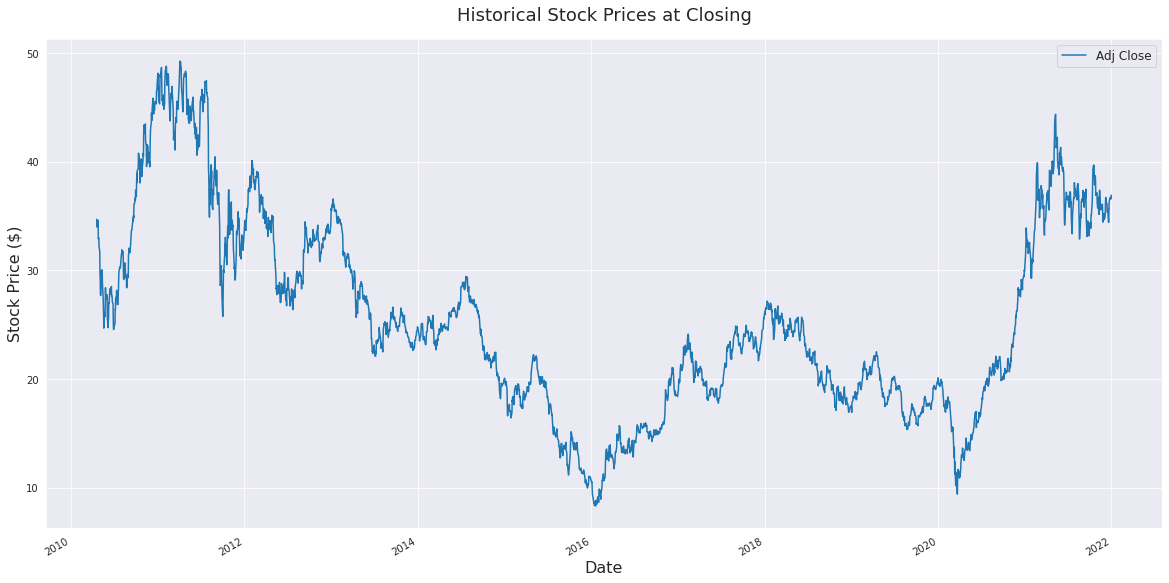

In [10]:
# Plot the trend of the stock prices at closing
df.plot(y=['Adj Close'], figsize=(20, 10))
plt.title('Historical Stock Prices at Closing', fontsize=18, y=1.025)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price ($)', fontsize=16)
plt.legend(fontsize='12')
plt.show()

#### Add technical indicators

According to **[Investopidia](https://www.investopedia.com/terms/t/technicalindicator.asp)**, technical indicators are heuristic or mathematical calculations based on the price, volume, or open interest of a security used by traders who follow technical analysis.

By analyzing historical data, technical analysts use indicators to predict future price movements.

##### Calculate the 3-Day and 9-Day Exponential Moving Average

An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. In general, moving averages smooth price data that can otherwise be visually noisy.

In [11]:
# Calculate the EMA values using and add them to the dataframe
df['EMA3'] = df['Adj Close'].ewm(span=3, adjust=False).mean()  # 3-day exponential moving average
df['EMA9'] = df['Adj Close'].ewm(span=9, adjust=False).mean()  # 9-day exponential moving average

In [12]:
# Inspect the data
df.head()

,High,Low,Open,Close,Volume,Adj Close,EMA3,EMA9
Date,,,,,,,,
2010-04-20,44.700001,43.950001,44.700001,44.040001,1933.0,34.699127,34.699127,34.699127
2010-04-21,44.099998,43.230000,43.799999,43.349998,2900.0,34.155479,34.427303,34.590398
2010-04-22,43.169998,42.509998,43.169998,43.110001,3600.0,33.966377,34.196840,34.465594
2010-04-23,43.259998,42.750000,42.959999,43.259998,1100.0,34.084560,34.140700,34.389387
2010-04-26,44.880001,43.200001,44.880001,43.919998,3600.0,34.604576,34.372638,34.432425


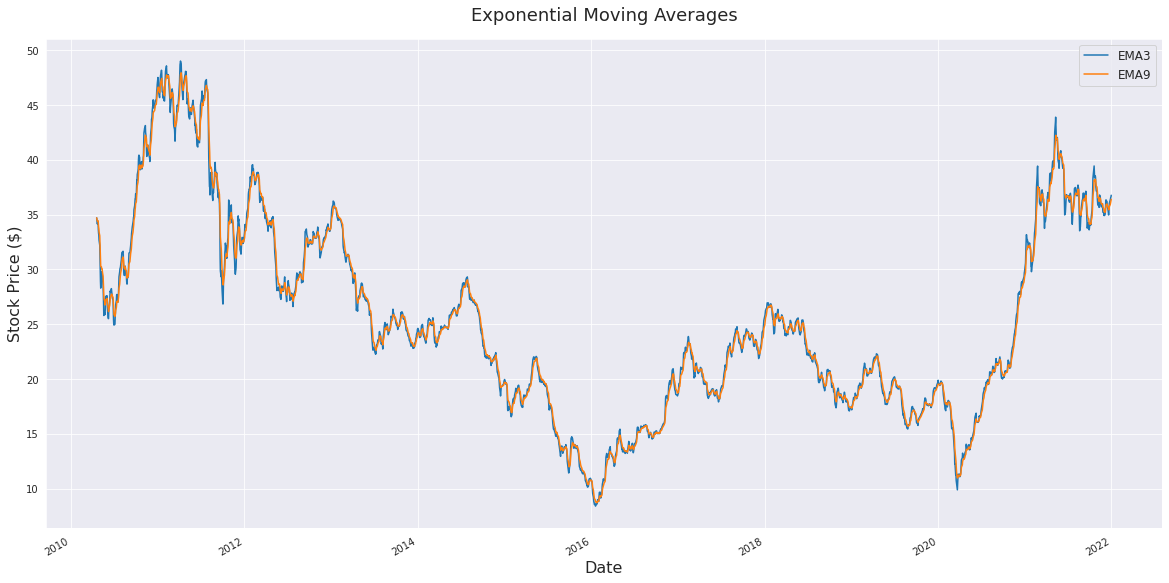

In [13]:
# Plot the 3-Day and 9-Day Exponential Moving Average
df.plot(y=['EMA3', 'EMA9'], figsize=(20, 10))
plt.title('Exponential Moving Averages', fontsize=18, y=1.025)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price ($)', fontsize=16)
plt.legend(fontsize='12')
plt.show()

#### Filter the dataset's features

For the rest of this project, we will only concern ourselves with these three features.

In [14]:
# Only keep the 'Adj Close,' 'EMA3' and 'EMA9' columns
df = df.loc[:, ['Adj Close','EMA3','EMA9']]

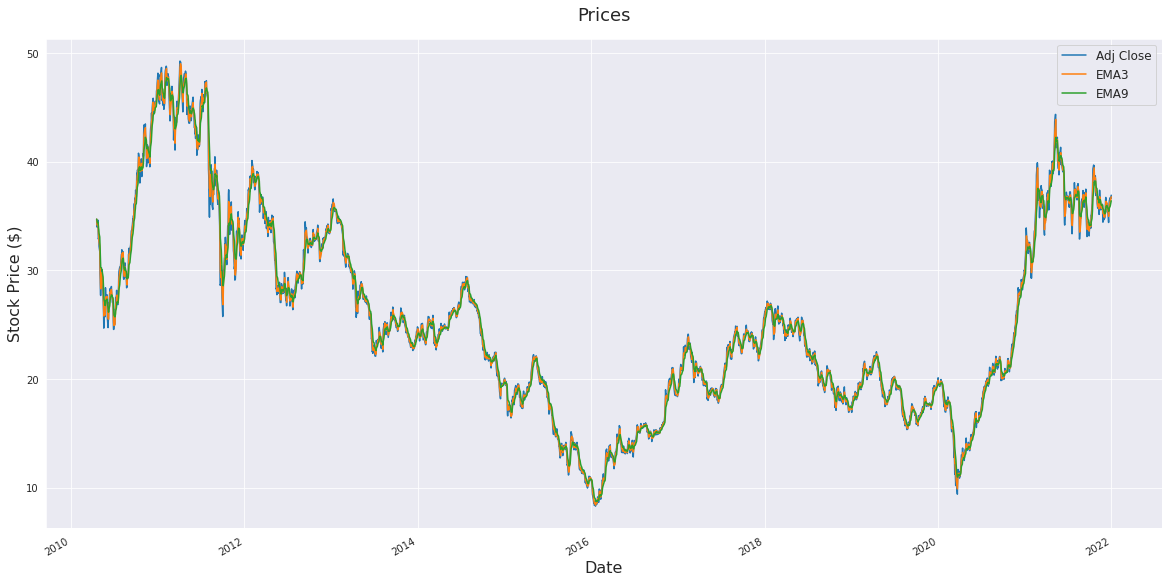

In [15]:
# Plot the adjusted closing price, the 3-Day and 9-Day Exponential Moving Averages
df.plot(figsize=(20, 10))
plt.title('Prices', fontsize=18, y=1.025)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price ($)', fontsize=16)
plt.legend(fontsize='12')
plt.show()

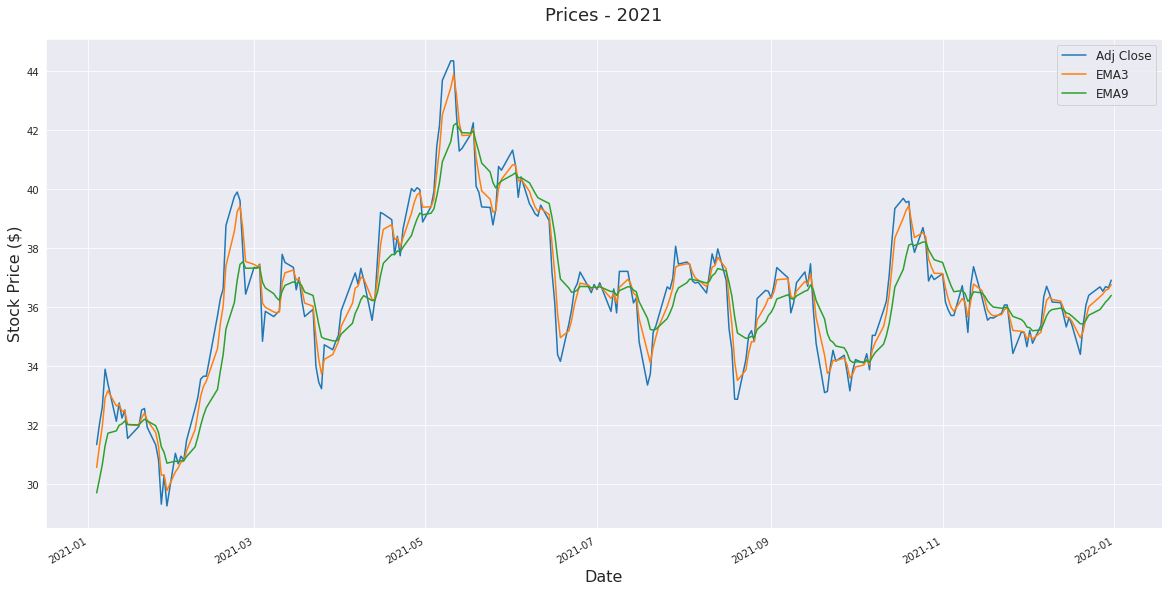

In [16]:
# Only consider the data for last year (2021)
df_2021 = df[dt.datetime(2021,1,1):dt.datetime(2021,12,31)]

# Plot the adjusted closing price, the 3-Day and 9-Day Exponential Moving Averages for last year
df_2021.plot(figsize=(20, 10))
plt.title('Prices - 2021', fontsize=18, y=1.025)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price ($)', fontsize=16)
plt.legend(fontsize='12')
plt.show()

#### Feature Engineering

In [17]:
# Compute the 'Next Day Price'
df['Next Day Price'] = df['Adj Close'].shift(-1)

# Drop all the rows where NaN values are present
df = df.dropna()

# Inspect the data once again
print(df)
print(df.info())

            Adj Close       EMA3       EMA9  Next Day Price
Date                                                       
2010-04-20  34.699127  34.699127  34.699127       34.155479
2010-04-21  34.155479  34.427303  34.590398       33.966377
2010-04-22  33.966377  34.196840  34.465594       34.084560
2010-04-23  34.084560  34.140700  34.389387       34.604576
2010-04-26  34.604576  34.372638  34.432425       32.879082
...               ...        ...        ...             ...
2021-12-23  36.398113  36.010707  35.724753       36.685104
2021-12-27  36.685104  36.347906  35.916823       36.536659
2021-12-28  36.536659  36.442282  36.040791       36.695004
2021-12-29  36.695004  36.568643  36.171633       36.650002
2021-12-30  36.650002  36.609322  36.267307       36.910000

[2947 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2947 entries, 2010-04-20 to 2021-12-30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          -----

## Part 2 - Machine Learning Algorithms

### Split the data into a train, a test and a validation datasets

In [18]:
# Store the explanatory features in X
X = df[['EMA3', 'EMA9']]
print(X)

                 EMA3       EMA9
Date                            
2010-04-20  34.699127  34.699127
2010-04-21  34.427303  34.590398
2010-04-22  34.196840  34.465594
2010-04-23  34.140700  34.389387
2010-04-26  34.372638  34.432425
...               ...        ...
2021-12-23  36.010707  35.724753
2021-12-27  36.347906  35.916823
2021-12-28  36.442282  36.040791
2021-12-29  36.568643  36.171633
2021-12-30  36.609322  36.267307

[2947 rows x 2 columns]


In [19]:
# Store the dependent feature in y
y = df[['Next Day Price']]
print(y)

            Next Day Price
Date                      
2010-04-20       34.155479
2010-04-21       33.966377
2010-04-22       34.084560
2010-04-23       34.604576
2010-04-26       32.879082
...                    ...
2021-12-23       36.685104
2021-12-27       36.536659
2021-12-28       36.695004
2021-12-29       36.650002
2021-12-30       36.910000

[2947 rows x 1 columns]


In [20]:
# Split the data into a training, a testing and a validation datasets. Because we are dealing with time series, we do not shuffle the data while splitting it.

# Create a validation dataset of 5% of the entire dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, shuffle=False)

# Create a test dataset of 20% of the entire dataset ==> (1 - 0.05) * 0.2 = 0.19
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.19)

In [21]:
# Split the data into a training, a testing and a validation datasets. Because we are dealing with time series, we do not shuffle the data while splitting it.

# Create a validation dataset of 5% of the entire dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, shuffle=False)

# Create a test dataset of 20% of the remaining data (after setting aside the original 5% for the validation dataset)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [22]:
# Training set
print(X_train.describe())

              EMA3         EMA9
count  2239.000000  2239.000000
mean     25.559571    25.578494
std       8.938521     8.911381
min       8.396351     8.718123
25%      19.315061    19.260539
50%      24.331252    24.376045
75%      30.645987    30.804998
max      49.004455    47.932880


In [23]:
# Testing set
print(X_test.describe())

             EMA3        EMA9
count  560.000000  560.000000
mean    21.897603   21.791577
std      7.741297    7.585205
min      9.882356   10.966656
25%     17.076646   17.035999
50%     19.499283   19.467009
75%     22.468925   22.072683
max     43.885003   42.230072


In [24]:
# Validation set
print(X_val.describe())

             EMA3        EMA9
count  148.000000  148.000000
mean    36.302648   36.388073
std      1.492860    1.332657
min     33.516286   34.127062
25%     35.345894   35.573475
50%     36.286617   36.299636
75%     36.930644   36.816341
max     40.816130   40.547030


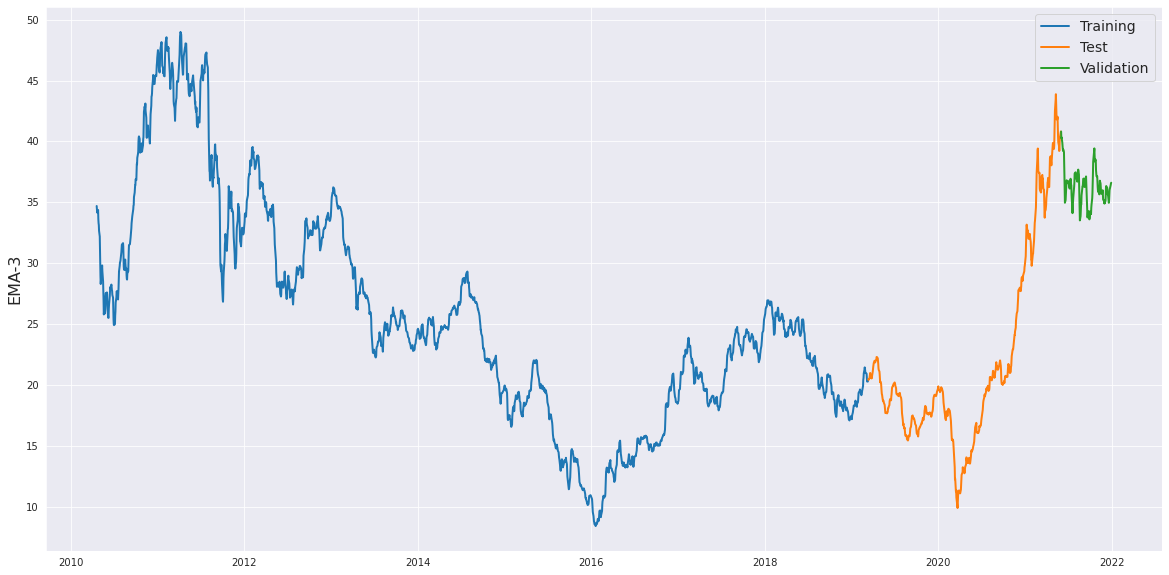

In [25]:
# Visualize the data splitting
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.plot(X_train['EMA3'], label='Training', linewidth=2)
ax.plot(X_test['EMA3'], label='Test', linewidth=2)
ax.plot(X_val['EMA3'], label='Validation', linewidth=2)
ax.set_ylabel('EMA-3', fontsize=16)
ax.legend(loc='best', fontsize=14);

### Define some useful functions

In [26]:
# Define a function that compute the Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Algorithms

#### 1. Predicting using Linear Regression

In [27]:
# Create a linear regression model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Use the model to make predictions
y1_pred = linear_model.predict(X_test)
y1_pred = pd.DataFrame(y1_pred, index=y_test.index, columns=['Predicted Price']) 

In [28]:
# Print some relevant metrics
print('Model Coefficients:', linear_model.coef_)
print('Model Intercept:', linear_model.intercept_)

Model Coefficients: [[ 1.43407633 -0.43798527]]
Model Intercept: [0.09548563]


In [29]:
# Store some relevant metrics
data = {'Model':['Linear Regression - Test'],
        'Mean Absolute Percentage Error':[mean_absolute_percentage_error(y_true=y_test, y_pred=y1_pred)],
        'Root Mean Square Error':[mean_squared_error(y_true=y_test, y_pred=y1_pred, squared=False)],
        'Coefficient of Determination':[r2_score(y_true=y_test, y_pred=y1_pred)]}

model_results = pd.DataFrame(data)#, index = [ticker])
model_results.iloc[0,:]

Model                             Linear Regression - Test
Mean Absolute Percentage Error                      1.8841
Root Mean Square Error                            0.598425
Coefficient of Determination                      0.994158
Name: 0, dtype: object

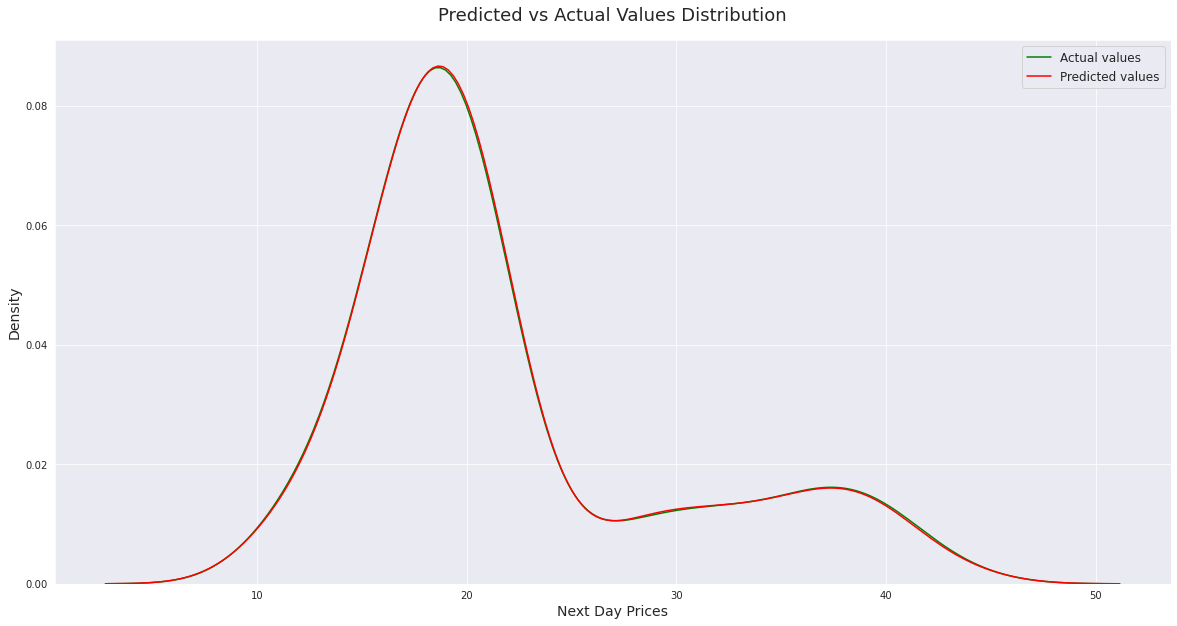

In [30]:
# Plot both the predicted and actual values
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Predicted vs Actual Values Distribution', fontsize=18, y=1.025)
sns.kdeplot(data=y_test.squeeze(), color="g", label='Actual values', ax=ax)
sns.kdeplot(data=y1_pred.squeeze(), color="r", label='Predicted values', ax=ax)

plt.legend(fontsize='12')
plt.xlabel('Next Day Prices', fontsize='14')
plt.ylabel('Density', fontsize='14')
plt.show()

In [31]:
# Print Actual values vs Predicted values
data_compare = pd.DataFrame({'Actual value': y_test['Next Day Price'], 'Predicted value': y1_pred['Predicted Price']})
print(data_compare)

            Actual value  Predicted value
Date                                     
2019-03-13     20.352438        20.453258
2019-03-14     20.457792        20.387176
2019-03-15     20.678080        20.425177
2019-03-18     20.869631        20.583848
2019-03-19     20.907940        20.778776
...                  ...              ...
2021-05-25     39.305111        38.722888
2021-05-26     40.763409        38.864948
2021-05-27     40.635319        39.877885
2021-05-28     41.315201        40.284602
2021-06-01     40.812675        40.903970

[560 rows x 2 columns]


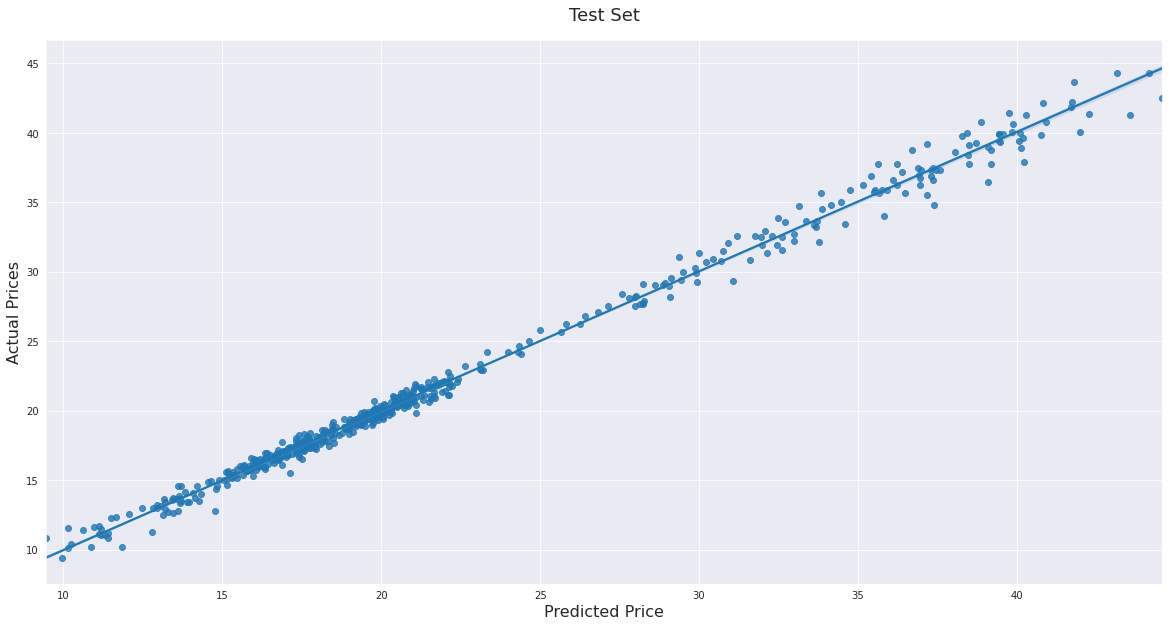

In [32]:
plt.figure(figsize=(20, 10))
plt.title('Test Set', fontsize=18, y=1.025)
plt.ylabel('Actual Prices', fontsize=16)
plt.xlabel('Predicted Prices', fontsize=16)
fig = sns.regplot(x=y1_pred, y=y_test.values)
plt.show(fig)

##### Test model on validation dataset

In [33]:
# Use the model to make predictions
y1_pred_val = linear_model.predict(X_val)
y1_pred_val = pd.DataFrame(y1_pred_val, index=y_val.index, columns=['Predicted Price']) 

In [34]:
# Store some relevant metrics
data = {'Model':'Linear Regression - Val',
        'Mean Absolute Percentage Error':mean_absolute_percentage_error(y_true=y_val, y_pred=y1_pred_val),
        'Root Mean Square Error':mean_squared_error(y_true=y_val, y_pred=y1_pred_val, squared=False),
        'Coefficient of Determination':r2_score(y_true=y_val, y_pred=y1_pred_val)}

model_results = model_results.append(data, ignore_index = True)
model_results.iloc[1,:]

Model                             Linear Regression - Val
Mean Absolute Percentage Error                    1.92661
Root Mean Square Error                            0.87421
Coefficient of Determination                     0.674198
Name: 1, dtype: object

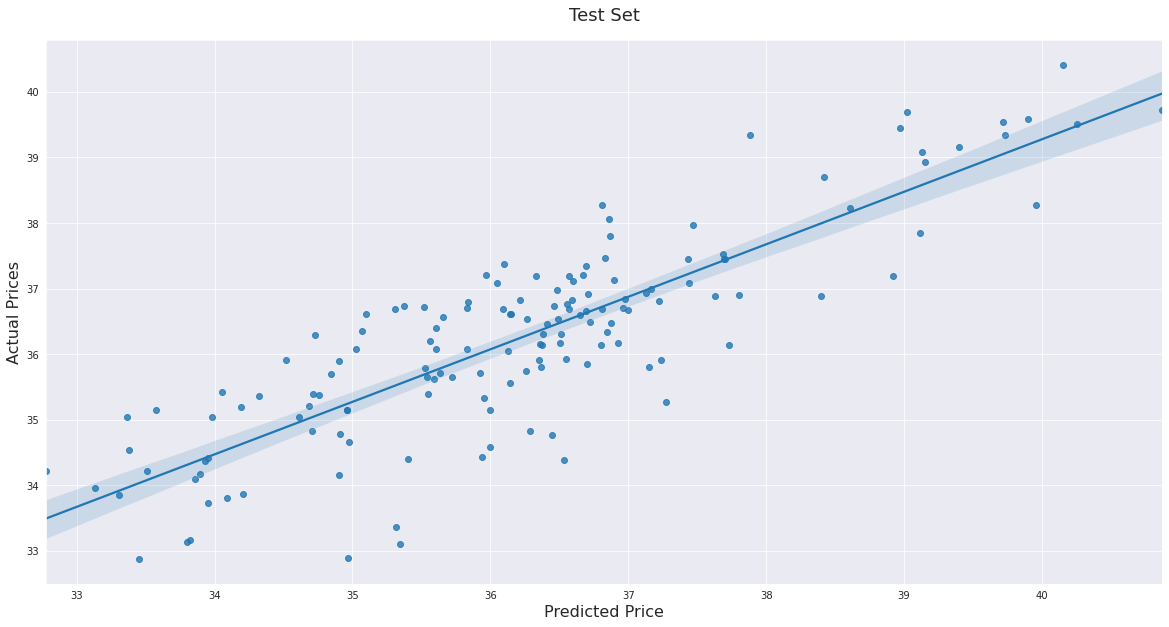

In [35]:
plt.figure(figsize=(20, 10))
plt.title('Test Set', fontsize=18, y=1.025)
plt.ylabel('Actual Prices', fontsize=16)
plt.xlabel('Predicted Prices', fontsize=16)
fig = sns.regplot(x=y1_pred_val, y=y_val.values)
plt.show(fig)

#### 2. Predicting using Random Forest

In [36]:
# Create a random forest regressos model
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train.values.ravel())

# Use the model to make predictions
y2_pred = rf_model.predict(X_test)
y2_pred = pd.DataFrame(y2_pred, index=y_test.index, columns=['Predicted Price']) 

In [37]:
# Store some relevant metrics
data = {'Model':'Random Forest - Test',
        'Mean Absolute Percentage Error':mean_absolute_percentage_error(y_true=y_test, y_pred=y2_pred),
        'Root Mean Square Error':mean_squared_error(y_true=y_test, y_pred=y2_pred, squared=False),
        'Coefficient of Determination':r2_score(y_true=y_test, y_pred=y2_pred)}

model_results = model_results.append(data, ignore_index = True)
model_results.iloc[1,:]

Model                             Linear Regression - Val
Mean Absolute Percentage Error                    1.92661
Root Mean Square Error                            0.87421
Coefficient of Determination                     0.674198
Name: 1, dtype: object

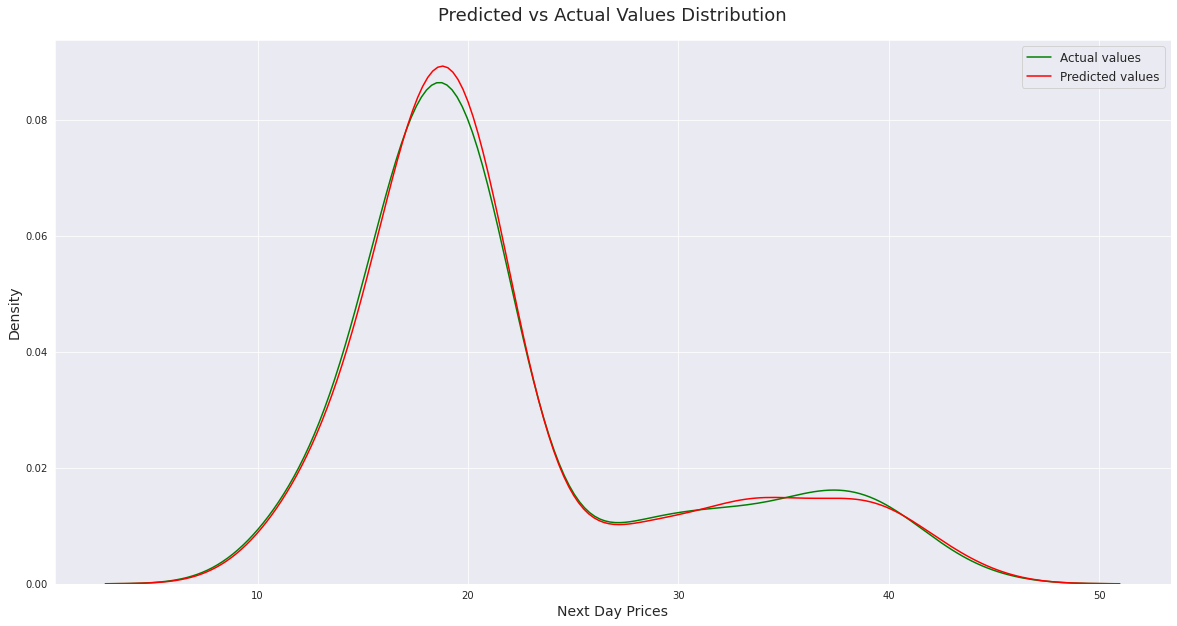

In [38]:
# Plot both the predicted and actual values
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Predicted vs Actual Values Distribution', fontsize=18, y=1.025)
sns.kdeplot(data=y_test.squeeze(), color="g", label='Actual values', ax=ax)
sns.kdeplot(data=y2_pred.squeeze(), color="r", label='Predicted values', ax=ax)

plt.legend(fontsize='12')
plt.xlabel('Next Day Prices', fontsize='14')
plt.ylabel('Density', fontsize='14')
plt.show()

In [39]:
# Print Actual values vs Predicted values
data_compare = pd.DataFrame({'Actual value': y_test['Next Day Price'], 'Predicted value': y2_pred['Predicted Price']})
print(data_compare)

            Actual value  Predicted value
Date                                     
2019-03-13     20.352438        20.551987
2019-03-14     20.457792        20.145090
2019-03-15     20.678080        20.191013
2019-03-18     20.869631        20.496932
2019-03-19     20.907940        20.736274
...                  ...              ...
2021-05-25     39.305111        40.379040
2021-05-26     40.763409        40.390444
2021-05-27     40.635319        40.563696
2021-05-28     41.315201        41.526913
2021-06-01     40.812675        41.631623

[560 rows x 2 columns]


##### Test model on validation dataset

In [40]:
# Use the model to make predictions
y2_pred_val = rf_model.predict(X_val)
y2_pred_val = pd.DataFrame(y2_pred_val, index=y_val.index, columns=['Predicted Price']) 

In [41]:
# Store some relevant metrics
data = {'Model':'Random Forest - Val',
        'Mean Absolute Percentage Error':mean_absolute_percentage_error(y_true=y_val, y_pred=y2_pred_val),
        'Root Mean Square Error':mean_squared_error(y_true=y_val, y_pred=y2_pred_val, squared=False),
        'Coefficient of Determination':r2_score(y_true=y_val, y_pred=y2_pred_val)}

model_results = model_results.append(data, ignore_index = True)
model_results.iloc[1,:]

Model                             Linear Regression - Val
Mean Absolute Percentage Error                    1.92661
Root Mean Square Error                            0.87421
Coefficient of Determination                     0.674198
Name: 1, dtype: object

#### 3. Predicting using Long Short-Term Memory (LSTM)

LTSMs are a type of Recurrent Neural Network (RCN) for learning long-term dependencies. It is commonly used for processing and predicting time-series data. 

In [42]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=25))
lstm_model.add(Dense(units=1))

In [43]:
# Compile the model
# - mean squared error is the loss function for optimizing the problem with adam optimizer
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
# View the model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Train the model
lstm_model.fit(np.array(X_train).reshape(-1,X_train.shape[1],1), y_train, batch_size=35, epochs=70, validation_split=.2, verbose=0)

# Use the model to make predictions
y3_pred = lstm_model.predict(np.array(X_test).reshape(-1,X_test.shape[1],1))
y3_pred = pd.DataFrame(y3_pred, index=y_test.index, columns=['Predicted Price'])

In [46]:
# Store some relevant metrics
data = {'Model':'LSTM - Test',
        'Mean Absolute Percentage Error':mean_absolute_percentage_error(y_true=y_test, y_pred=y3_pred),
        'Root Mean Square Error':mean_squared_error(y_true=y_test, y_pred=y3_pred, squared=False),
        'Coefficient of Determination':r2_score(y_true=y_test, y_pred=y3_pred)}

model_results = model_results.append(data, ignore_index = True)
model_results.iloc[2,:]

Model                             Random Forest - Test
Mean Absolute Percentage Error                 2.33574
Root Mean Square Error                        0.693306
Coefficient of Determination                  0.992158
Name: 2, dtype: object

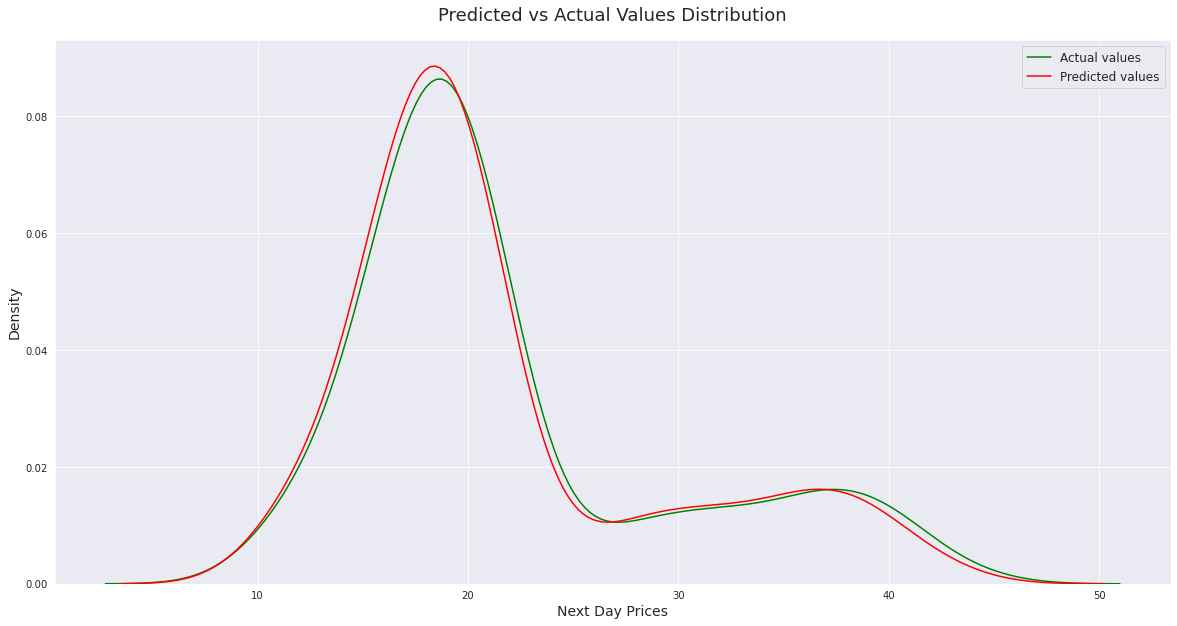

In [47]:
# Plot both the predicted and actual values
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Predicted vs Actual Values Distribution', fontsize=18, y=1.025)
sns.kdeplot(data=y_test.squeeze(), color="g", label='Actual values', ax=ax)
sns.kdeplot(data=y3_pred.squeeze(), color="r", label='Predicted values', ax=ax)

plt.legend(fontsize='12')
plt.xlabel('Next Day Prices', fontsize='14')
plt.ylabel('Density', fontsize='14')
plt.show()

In [48]:
# Print Actual values vs Predicted values
data_compare = pd.DataFrame({'Actual value': y_test['Next Day Price'], 'Predicted value': y3_pred['Predicted Price']})
print(data_compare)

            Actual value  Predicted value
Date                                     
2019-03-13     20.352438        20.154642
2019-03-14     20.457792        20.094547
2019-03-15     20.678080        20.123848
2019-03-18     20.869631        20.259396
2019-03-19     20.907940        20.430450
...                  ...              ...
2021-05-25     39.305111        38.506271
2021-05-26     40.763409        38.590881
2021-05-27     40.635319        39.464016
2021-05-28     41.315201        39.819759
2021-06-01     40.812675        40.372459

[560 rows x 2 columns]


##### Test model on validation dataset

In [49]:
# Use the model to make predictions
y3_pred_val = lstm_model.predict(np.array(X_val).reshape(-1,X_val.shape[1],1))
y3_pred_val = pd.DataFrame(y3_pred_val, index=y_val.index, columns=['Predicted Price'])

In [50]:
# Store some relevant metrics
data = {'Model':'LSTM - Val',
        'Mean Absolute Percentage Error':mean_absolute_percentage_error(y_true=y_val, y_pred=y3_pred_val),
        'Root Mean Square Error':mean_squared_error(y_true=y_val, y_pred=y3_pred_val, squared=False),
        'Coefficient of Determination':r2_score(y_true=y_val, y_pred=y3_pred_val)}

model_results = model_results.append(data, ignore_index = True)
model_results.iloc[1,:]

Model                             Linear Regression - Val
Mean Absolute Percentage Error                    1.92661
Root Mean Square Error                            0.87421
Coefficient of Determination                     0.674198
Name: 1, dtype: object

#### 4. Summary

In [51]:
model_results

,Model,Mean Absolute Percentage Error,Root Mean Square Error,Coefficient of Determination
0,Linear Regression - Test,1.884101,0.598425,0.994158
1,Linear Regression - Val,1.926614,0.874210,0.674198
2,Random Forest - Test,2.335735,0.693306,0.992158
3,Random Forest - Val,2.515219,1.095089,0.488764
4,LSTM - Test,2.463661,0.730451,0.991295
5,LSTM - Val,2.416549,1.046492,0.533132


We will use to performance metrics to chosse our best performing machine learning model. They are:
* the Root Mean Square Error is one of the most commonly used measures for evaluating the quality of predictions. It shows how far predictions fall from measured true values using Euclidean distance;
* the Coefficient of Determination tells one how well the data fits the model. It can take any values from 0 to 1, the closer to 1 the better the model fit.

By comparing these metrics obtained from  both our testing and validation sessions, it appears that our best performing model is our **Linear Regression** one.

## Part 3 - Model Implementation and Deployment on AWS

### Get the Data from S3

In [52]:
# Setup variables to point to S3
ticker = 'COPX'
fileName = 'stock_market_data-{}.csv'.format(ticker)

bucket = 'project-6'
data_prefix = 'data'
train_prefix = 'train'
output_prefix = 'output'

s3_data_path = "{}/{}".format(data_prefix, fileName)
s3_train_path = "{}/{}".format(train_prefix, fileName)

s3_train_data = "s3://{}/{}".format(bucket, s3_train_path)
s3_output_location = "s3://{}/{}".format(bucket, output_prefix)

In [53]:
# Get data from S3
s3_client = boto3.client('s3')
obj = s3_client.get_object(Bucket=bucket, Key=s3_data_path)
df = pd.read_csv(io.BytesIO(obj['Body'].read()))

### Prepare the Data

In [54]:
# Inspect the data
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-04-20,44.700001,43.950001,44.700001,44.040001,1933.0,34.699127
1,2010-04-21,44.099998,43.230000,43.799999,43.349998,2900.0,34.155479
2,2010-04-22,43.169998,42.509998,43.169998,43.110001,3600.0,33.966377
3,2010-04-23,43.259998,42.750000,42.959999,43.259998,1100.0,34.084560
4,2010-04-26,44.880001,43.200001,44.880001,43.919998,3600.0,34.604576


In [55]:
# Reindex data using a DatetimeIndex
df.set_index(pd.DatetimeIndex(df['Date']), inplace=True)

# Keep only the 'Adj Close' Value
df = df[['Adj Close']]

# Re-inspect the data
print(df)

            Adj Close
Date                 
2010-04-20  34.699127
2010-04-21  34.155479
2010-04-22  33.966377
2010-04-23  34.084560
2010-04-26  34.604576
...               ...
2021-12-27  36.685104
2021-12-28  36.536659
2021-12-29  36.695004
2021-12-30  36.650002
2021-12-31  36.910000

[2948 rows x 1 columns]


In [56]:
# Print a concise summary of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2948 entries, 2010-04-20 to 2021-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2948 non-null   float64
dtypes: float64(1)
memory usage: 46.1 KB
None


In [57]:
# Drop rows with any empty cells (if any)
if df.isnull().any().any():
    print('Empty cells found - rows dropped')
    df.dropna(axis=0, how='any', inplace=True)
else:
    print('No empty cells found')

No empty cells found


In [58]:
# Calculate the EMA values add them to the dataframe
df['EMA3'] = df['Adj Close'].ewm(span=3, adjust=False).mean()  # 3-day exponential moving average
df['EMA9'] = df['Adj Close'].ewm(span=9, adjust=False).mean()  # 9-day exponential moving average

In [59]:
# Inspect the data
df.head()

,Adj Close,EMA3,EMA9
Date,,,
2010-04-20,34.699127,34.699127,34.699127
2010-04-21,34.155479,34.427303,34.590398
2010-04-22,33.966377,34.196840,34.465594
2010-04-23,34.084560,34.140700,34.389387
2010-04-26,34.604576,34.372638,34.432425


In [60]:
# Compute the 'Next Day Price'
df['Next Day Price'] = df['Adj Close'].shift(-1)

# Drop all the rows where NaN values are present
df = df.dropna()

# Inspect the data once again
print(df)
print(df.info())

            Adj Close       EMA3       EMA9  Next Day Price
Date                                                       
2010-04-20  34.699127  34.699127  34.699127       34.155479
2010-04-21  34.155479  34.427303  34.590398       33.966377
2010-04-22  33.966377  34.196840  34.465594       34.084560
2010-04-23  34.084560  34.140700  34.389387       34.604576
2010-04-26  34.604576  34.372638  34.432425       32.879082
...               ...        ...        ...             ...
2021-12-23  36.398113  36.010707  35.724753       36.685104
2021-12-27  36.685104  36.347906  35.916823       36.536659
2021-12-28  36.536659  36.442282  36.040791       36.695004
2021-12-29  36.695004  36.568643  36.171633       36.650002
2021-12-30  36.650002  36.609322  36.267307       36.910000

[2947 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2947 entries, 2010-04-20 to 2021-12-30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          -----

### Define the Dependent and Independent Variables

In [61]:
# Store the explanatory features in X
X = df[['EMA3', 'EMA9']]
print(X)

                 EMA3       EMA9
Date                            
2010-04-20  34.699127  34.699127
2010-04-21  34.427303  34.590398
2010-04-22  34.196840  34.465594
2010-04-23  34.140700  34.389387
2010-04-26  34.372638  34.432425
...               ...        ...
2021-12-23  36.010707  35.724753
2021-12-27  36.347906  35.916823
2021-12-28  36.442282  36.040791
2021-12-29  36.568643  36.171633
2021-12-30  36.609322  36.267307

[2947 rows x 2 columns]


In [62]:
# Store the dependent feature in y
y = df['Next Day Price']
print(y)

Date
2010-04-20    34.155479
2010-04-21    33.966377
2010-04-22    34.084560
2010-04-23    34.604576
2010-04-26    32.879082
                ...    
2021-12-23    36.685104
2021-12-27    36.536659
2021-12-28    36.695004
2021-12-29    36.650002
2021-12-30    36.910000
Name: Next Day Price, Length: 2947, dtype: float64


### Split the data into a training and a validation datasets

In [63]:
# Split the data into a training and a validation datasets. Because we are dealing with time series, we do not shuffle the data while splitting it.

# Create a validation dataset of 5% of the entire dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, shuffle=False)

In [64]:
# Convert the daraframes to NumPy arrays
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

In [65]:
# Store the training data in your S3 bucket by converting it into RecordIO Protobuf format
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train.astype("float32"), y_train.astype("float32"))
#smac.write_numpy_to_dense_tensor(buf, X_train.values, y_train.values)
buf.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(s3_train_path).upload_fileobj(buf)

print('Uploaded training data location: {}'.format(s3_train_data))

Uploaded training data location: s3://project-6/train/stock_market_data-COPX.csv


### Define the Docker Container

In [66]:
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='linear-learner')
print(container)

382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


### Construct the SageMaker Estimator

In [67]:
role = get_execution_role()
session = sagemaker.Session()

# Set up the estimator
linear_model = sagemaker.estimator.Estimator(image_uri=container,
                                             role=role,
                                             instance_count=1,
                                             instance_type='ml.m4.xlarge',
                                             output_path=s3_output_location,
                                             sagemaker_session=session)

In [68]:
# Set up the hyperparameters
linear_model.set_hyperparameters(feature_dim=X_train.shape[1],
                                 epochs=20,
                                 num_models=32,
                                 loss='absolute_loss',
                                 predictor_type='regressor',
                                 mini_batch_size=32,
                                 normalize_data=True,
                                 normalize_label=False)

In [69]:
# Configure a data input flow for training
train_input = TrainingInput(
   s3_train_data
)

In [70]:
# Train a model
job_name = 'project-6-{}'.format(dt.datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
linear_model.fit({'train': train_input}, job_name=job_name)

2022-01-14 20:17:23 Starting - Starting the training job...
2022-01-14 20:17:47 Starting - Launching requested ML instancesProfilerReport-1642191443: InProgress
......
2022-01-14 20:18:50 Starting - Preparing the instances for training.........
2022-01-14 20:20:28 Downloading - Downloading input data...
2022-01-14 20:20:48 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/14/2022 20:21:13 INFO 139628928325440] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer':

### Deploy the Model

In [72]:
linear_predictor = linear_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name="project-6-endpoint")

--------!

### Evaluate the Model

In [131]:
# View the type of the validation data
print(type(X_val))

<class 'numpy.ndarray'>


In [132]:
# View the dimensionality of the validation data
X_val.shape

(148, 2)

In [133]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [135]:
# Making prediction on the validation data
result = linear_predictor.predict(X_val)
result

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'score': 40.585487365722656},
  {'score': 40.229400634765625},
  {'score': 40.267425537109375},
  {'score': 39.97119903564453},
  {'score': 39.74205017089844},
  {'score': 39.536712646484375},
  {'score': 39.380638122558594},
  {'score': 39.41009521484375},
  {'score': 39.23533630371094},
  {'score': 38.52203369140625},
  {'score': 37.72966003417969},
  {'score': 36.63640594482422},
  {'score': 35.89061737060547},
  {'score': 35.854644775390625},
  {'score': 35.963348388671875},
  {'score': 36.23662567138672},
  {'score': 36.441619873046875},
  {'score': 36.68952178955078},
  {'score': 36.656272888183594},
  {'score': 36.570587158203125},
  {'score': 36.61821746826172},
  {'score': 36.586647033691406},
  {'score': 36.64787292480469},
  {'score': 36.345191955566406},
  {'score': 36.43480682373047},
  {'score': 36.199378967285156},
  {'score': 36.549827575683594},
  {'score': 36.749046325683594},
  {'score': 36.67809295654297},
  {'score': 36.459075927734375},
  {'score

In [136]:
# Access the scores by iterating through the scores in predictions
predictions = [x['score'] for x in result['predictions']]
print(predictions[0:5])

[40.585487365722656, 40.229400634765625, 40.267425537109375, 39.97119903564453, 39.74205017089844]


In [138]:
# Compare the actual closing prices with the predicted ones
df_results = pd.DataFrame({
    'Actual Price': y_val.tolist(),
    'Predicted Price': predictions
})

df_results

,Actual Price,Predicted Price
0,39.718952,40.585487
1,40.408688,40.229401
2,39.502178,40.267426
3,39.344524,39.971199
4,39.157314,39.742050
...,...,...
143,36.685104,35.810585
144,36.536659,36.073784
145,36.695004,36.181931
146,36.650002,36.309479


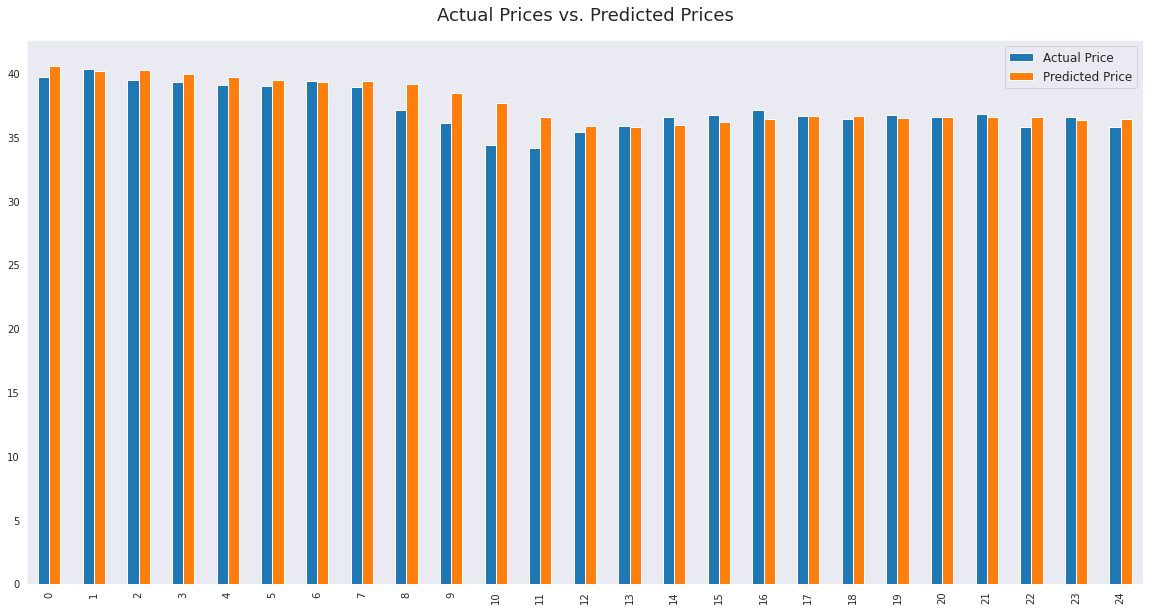

In [139]:
# Partial comparison visualization of the result as a bar graph
df_partial = df_results.head(25)
df_partial.plot(y=['Actual Price', 'Predicted Price'], kind='bar', figsize=(20, 10))

plt.title('Actual Prices vs. Predicted Prices', fontsize=18, y=1.025)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.legend(fontsize='12')
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
sns.regplot(np.array(predictions),np.array(y_holdout.values))

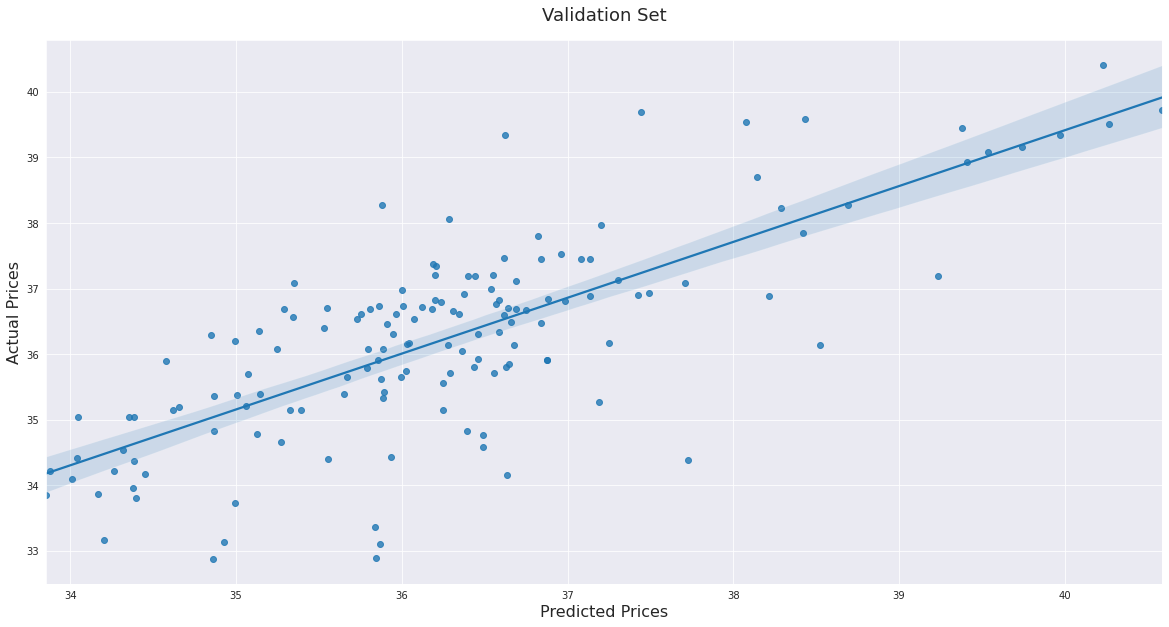

In [142]:
plt.figure(figsize=(20, 10))
plt.title('Validation Set', fontsize=18, y=1.025)
plt.ylabel('Actual Prices', fontsize=16)
plt.xlabel('Predicted Prices', fontsize=16)
fig = sns.regplot(x=np.array(predictions), y=np.array(y_val.tolist()))
plt.show(fig)

### Delete the Enpoint

In [143]:
# To avoid unnecessary costs, the endpoint should be deleted once no longer needed
linear_predictor.delete_endpoint()